<a href="https://colab.research.google.com/github/SoniaPMi/AI-3-PyTorch/blob/main/4_MLPvsRNN_Ejercicio_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

#<strong><center>Series temporales con RNNs y MLP en KERAS: Ejercicio</center></strong>

Info de Tensor Flow sobre RNN
https://www.tensorflow.org/guide/keras/rnn

En este ejercicio se propone realizar un estudio similar al del anterior notebook. En este caso se va a emplear un dataset de datos reales 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

Importamos el fichero de repositorio

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2022-02-05 09:15:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.148.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-02-05 09:15:10 (54.7 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



Lo cargamos y ploteamos para ver su aspecto y comprobar que todo ha ido bien:

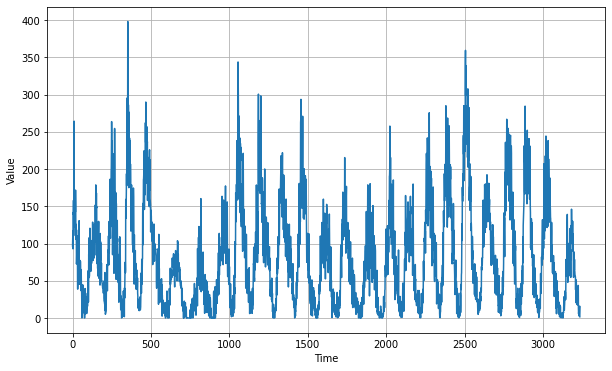

In [3]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

##Inicio del ejercicio

Preparación de parámetros
Configura los parámetros segun estas directrices iniciales:  
* conjunto de entrenamiento sea de 3000 muestras y el resto de validación
* Enventanado de 60 muestras
* Tamaño de lote de 128
* Tamaño de mezcla de buffer de 1000


In [4]:
# Tu código aquí: 

#split time : time step
#series : sunspots (actividad solar / manchas solares)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60 #enventanado
batch_size = 128 #tamaño lote
shuffle_buffer_size = 1000 #


La función que prepara el dataset a partir del enventanado y parámetros especificados se mantiene igual

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Modelo con RNN

Crea el dataset empleando la función anterior `windowed_dataset`: 


In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Tu código aquí: 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


Define el modelo de RNN simple con 2 capas de 40 y 40 neuronas respectivamente y la misma arquitectura del ejercicio anterior

In [11]:
# Tu código aquí: 
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  #return_sequences: Boolean. 
  #Whether to return the last output in the output sequence, or the full sequence. Default: False.
  #devolver toda la secuencia de salidas para cada muestra (return_sequences=True)
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 100.0) ## add a x -> 100x layer
])

In [ ]:
#SALIDA DE UN RNN
#(batch_size, timesteps, units)


Comprueba su arquitectura y cantidad de parámetros

In [12]:
# Tu código aquí: 
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, None, 1)           0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, None, 40)          1680      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# Tu código aquí: 

train_set = indowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20)) #en cada epoca disminuyo la tasa de aprendizaje
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [17]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
23/23 [==============================] - 8s 185ms/step - loss: 89.2044 - mae: 89.7043 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 5s 181ms/step - loss: 87.1260 - mae: 87.6259 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 5s 186ms/step - loss: 84.5899 - mae: 85.0893 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 5s 181ms/step - loss: 81.8709 - mae: 82.3708 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 5s 188ms/step - loss: 78.9636 - mae: 79.4633 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 5s 185ms/step - loss: 75.8593 - mae: 76.3585 - lr: 1.7783e-08
Epoch 7/100
23/23 [==============================] - 5s 183ms/step - loss: 72.6116 - mae: 73.1107 - lr: 1.9953e-08
Epoch 8/100
23/23 [==============================] - 5s 184ms/step - loss: 69.2759 - mae: 69.7741 - lr: 2.2387e-08
Epoch 9/100
23/23 [==============================] - 5s 190ms/step - loss: 65.91

Antes de su entrenamiento definitivo, realiza una exploración sobre el conjunto de entrenamiento para determinar un learning rate óptimo

Visualiza el error para elegir el mejor lr

(1e-08, 0.0001, 0.0, 30.0)

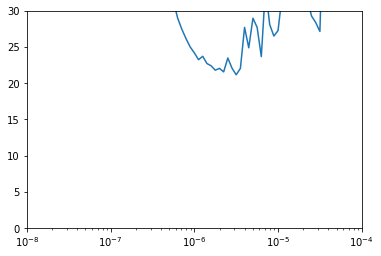

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
#3*10^-5

Configura ahora y reentrena con la tasa de lr elegida, tal como hemos hecho en el ejercicio anterior y 200 epochs

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Tu código aquí: 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=3e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, epochs=200)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/200
23/23 [==============================] - 6s 189ms/step - loss: 60.2527 - mae: 60.7508
Epoch 2/200
23/23 [==============================] - 5s 187ms/step - loss: 33.3544 - mae: 33.8504
Epoch 3/200
23/23 [==============================] - 5s 190ms/step - loss: 28.0793 - mae: 28.5747
Epoch 4/200
23/23 [==============================] - 5s 190ms/step - loss: 25.7916 - mae: 26.2871
Epoch 5/200
23/23 [==============================] - 5s 188ms/step - loss: 24.3664 - mae: 24.8621
Epoch 6/200
23/23 [==============================] - 5s 190ms/step - loss: 24.9746 - mae: 25.4685
Epoch 7/200
23/23 [==============================] - 5s 191ms/step - loss: 23.2507 - mae: 23.7448
Epoch 8/200
23/23 [==============================] - 5s 213ms/step - loss: 23.4286 - mae: 23.9239
Epoch 9/200
23/23 [==============================] - 5s 187ms/step - loss: 22.1540 - mae: 22.6487
Epoch 10/200
23/23 [==============================] - 5s 190ms/step - loss: 22.1524 - mae: 22.6452
Epoch 11/200
23/23 

Realizamos predicciones y visualizamos resultados igual que en ejemplo anterior

In [ ]:
forecast=[]

# Tu código aquí: 

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0] #array numpy para poder plotear 


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

Obtenemos una métrica de error numérica para poder realizar comparaciones: 

In [ ]:
# Tu código aquí: 
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Visualiza el error y la métrica de salida MAE para ver su relación. Los valores los tenemos en la lista history[ ]

## Modelo con MLP (*MultiLayer Perceptron*)

Vamos ahora a plantear un modelo equivalente con la red neuronal multicapa. 

Implementa el mismo numero de capas (2) y neuronas por (20 y 10) capa con función de activación "relu"

In [ ]:
# Tu código aquí: 
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, input_shape=[window_size], activation="relu"),  #aqui no +1, no es RNN
    tf.keras.layers.Dense(40, activation="relu"), 
    tf.keras.layers.Dense(1)
])


Comprueba arquitectura y parámetros

In [ ]:
# Tu código aquí: 
print(model2.summary())

Mismos parámetros de compilacion, pérdida y optimizador

In [ ]:
model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

Entrena durante el mismo número de epochs (200)

In [ ]:
# Tu código aquí: 

model2.fit(dataset, epochs=200, verbose=0)

Prediccion y visualización de resultados

In [ ]:
forecast = []

# Tu código aquí: 
for time in range(len(series) - window_size):
  forecast.append(model2.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


Métrica de resultados

In [ ]:
# Tu código aquí: 
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


Enhorabuena, has llegado al final del ejercicio!

Ahora reflexiona sobre los resultados obtenidos: 
* ¿Cual ha funcionado mejor? 
* ¿Porqué crees que es?

Repite el entrenamiento variando diferentes parámetros y observa como influyen en los resultados y los tiempos: 
* tamaño del lote
* arquitectura de la red - nº de neuronas
* tasa de aprendizaje
* nº de epochs
* enventanado

In [ ]:
'''
segun el problema, las redes drecurrentes son muy buenas, 
ya que en versiones avanzadas podremos obtener infor de otro momento

en este caso no vemos demasiada diferencia respecto el perceptón multicapa.




'''

##Referencias


*   Documento inspirado en los ejemplos del repositorio de LaurenceMorone y en su curso de Deep Learning con TensorFlow: https://github.com/lmoroney?tab=repositories 
* Doc oficial Pytorch https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html


##Fin del cuaderno